In [2]:
import datetime as dt
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
conn = sqlite3.connect('data/FPA_FOD_20170508.sqlite')

# Data Pre-Processing

## Feature Selection from the dataset

In [4]:
df = pd.read_sql_query("SELECT STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,SOURCE_REPORTING_UNIT_NAME,FIRE_SIZE_CLASS,FIRE_YEAR,CONT_DATE FROM 'Fires'", conn)

In [5]:
print(df.head())

  STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  FIRE_SIZE  \
0    Miscellaneous  40.036944 -121.005833    CA       2453403.5       0.10   
1        Lightning  38.933056 -120.404444    CA       2453137.5       0.25   
2   Debris Burning  38.984167 -120.735556    CA       2453156.5       0.10   
3        Lightning  38.559167 -119.913333    CA       2453184.5       0.10   
4        Lightning  38.559167 -119.933056    CA       2453184.5       0.10   

  SOURCE_REPORTING_UNIT_NAME FIRE_SIZE_CLASS  FIRE_YEAR  CONT_DATE  
0     Plumas National Forest               A       2005  2453403.5  
1   Eldorado National Forest               A       2004  2453137.5  
2   Eldorado National Forest               A       2004  2453156.5  
3   Eldorado National Forest               A       2004  2453189.5  
4   Eldorado National Forest               A       2004  2453189.5  


## Convert date from Julian to Gregorian calendar format

In [7]:
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['DAY_OF_WEEK'] = pd.to_datetime(df['DISCOVERY_DATE']).dt.weekday_name
df['MONTH'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).month
df['CONT_DATE'] = pd.to_datetime(df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')

In [9]:
print(df.head())

  STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE DISCOVERY_DATE  FIRE_SIZE  \
0    Miscellaneous  40.036944 -121.005833    CA     2005-02-02       0.10   
1        Lightning  38.933056 -120.404444    CA     2004-05-12       0.25   
2   Debris Burning  38.984167 -120.735556    CA     2004-05-31       0.10   
3        Lightning  38.559167 -119.913333    CA     2004-06-28       0.10   
4        Lightning  38.559167 -119.933056    CA     2004-06-28       0.10   

  SOURCE_REPORTING_UNIT_NAME FIRE_SIZE_CLASS  FIRE_YEAR  CONT_DATE       DATE  \
0     Plumas National Forest               A       2005 2005-02-02 2005-02-02   
1   Eldorado National Forest               A       2004 2004-05-12 2004-05-12   
2   Eldorado National Forest               A       2004 2004-05-31 2004-05-31   
3   Eldorado National Forest               A       2004 2004-07-03 2004-06-28   
4   Eldorado National Forest               A       2004 2004-07-03 2004-06-28   

  DAY_OF_WEEK  MONTH  
0   Wednesday      2  
1   

# Charts

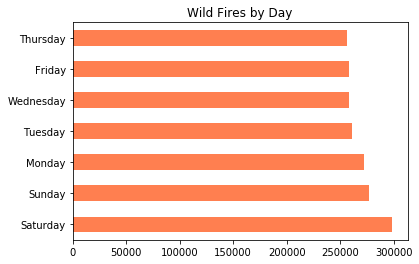

In [27]:
df['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral', title ="Wild Fires by Day")
plt.show()

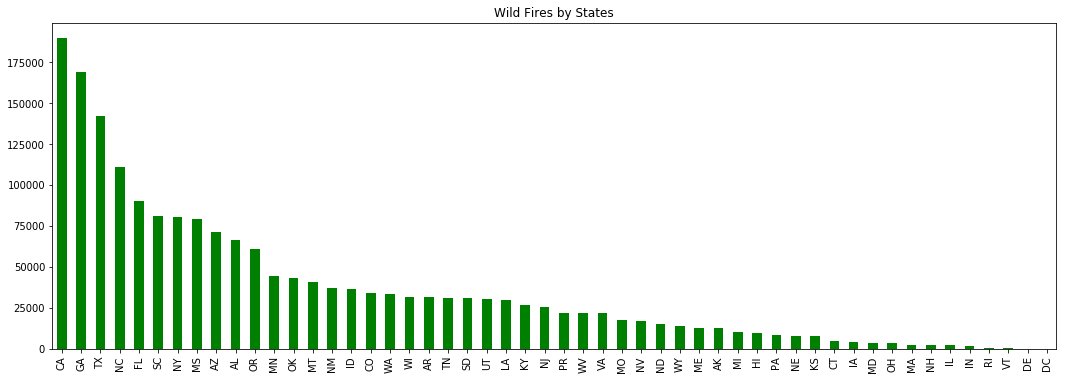

In [25]:
df['STATE'].value_counts().plot(kind='bar',color='green', figsize=(18, 6), title ="Wild Fires by States")
plt.show()

In [19]:
cause_df = df.groupby(['STAT_CAUSE_DESCR']).size().reset_index(name='COUNT')

In [20]:
print(cause_df)

     STAT_CAUSE_DESCR   COUNT
0               Arson  281455
1            Campfire   76139
2            Children   61167
3      Debris Burning  429028
4       Equipment Use  147612
5           Fireworks   11500
6           Lightning  278468
7       Miscellaneous  323805
8   Missing/Undefined  166723
9           Powerline   14448
10           Railroad   33455
11            Smoking   52869
12          Structure    3796


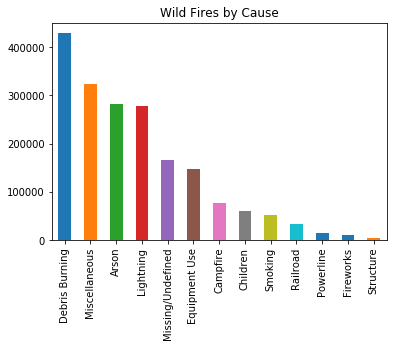

In [35]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='bar', title ="Wild Fires by Cause")

# Support Vector Machine (SVM)

In [45]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['STAT_CAUSE_DESCR'] = le.fit_transform(df['STAT_CAUSE_DESCR'])
df['STATE'] = le.fit_transform(df['STATE'])
df['DAY_OF_WEEK'] = le.fit_transform(df['DAY_OF_WEEK'])
df['MONTH'] = le.fit_transform(df['MONTH'])
df['FIRE_SIZE_CLASS'] = le.fit_transform(df['FIRE_SIZE_CLASS'])
print(df.head())

   STAT_CAUSE_DESCR   LATITUDE   LONGITUDE  STATE DISCOVERY_DATE  FIRE_SIZE  \
0                 6  40.036944 -121.005833      4     2005-02-02       0.10   
1                 5  38.933056 -120.404444      4     2004-05-12       0.25   
2                 3  38.984167 -120.735556      4     2004-05-31       0.10   
3                 5  38.559167 -119.913333      4     2004-06-28       0.10   
4                 5  38.559167 -119.933056      4     2004-06-28       0.10   

  SOURCE_REPORTING_UNIT_NAME  FIRE_SIZE_CLASS  FIRE_YEAR  CONT_DATE  \
0     Plumas National Forest                0       2005 2005-02-02   
1   Eldorado National Forest                0       2004 2004-05-12   
2   Eldorado National Forest                0       2004 2004-05-31   
3   Eldorado National Forest                0       2004 2004-07-03   
4   Eldorado National Forest                0       2004 2004-07-03   

                  DATE  DAY_OF_WEEK  MONTH  
0  1107302400000000000            6      1  
1  10843

In [40]:
# import matplotlib.pyplot as plt
# def heat_map(df,size=10):
#     corr = df.corr()  #the default method is pearson
#     print(corr)
#     fig, ax = plt.subplots(figsize=(size, size))
#     ax.matshow(corr,cmap=plt.cm.Oranges)
#     plt.xticks(range(len(corr.columns)), corr.columns)
#     plt.yticks(range(len(corr.columns)), corr.columns)
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(45)    
#     plt.show()
    

    
# heat_map(df)

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split  

X = df[['FIRE_YEAR','DAY_OF_WEEK','MONTH','STATE', 'LATITUDE','LONGITUDE','FIRE_SIZE_CLASS']]
y = df['STAT_CAUSE_DESCR']

df = df.head(50000)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)
model = svm.SVC(gamma='scale')

model.fit(X_train, y_train)

In [56]:
y_pred = model.predict(X_test)
y_pred 

array([5, 5, 5, ..., 5, 5, 5])

In [57]:
from sklearn.metrics import classification_report,accuracy_score  
print("Classification Report")
print(classification_report(y_test,y_pred))  
print("Score for SVM is:",model.score(X_train, y_train))
print("Accuracy score:",accuracy_score(y_test,y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.36      0.60      0.45       779
           1       0.21      0.00      0.01      1329
           2       0.00      0.00      0.00        80
           3       0.16      0.02      0.03       496
           4       0.00      0.00      0.00       354
           5       0.62      0.97      0.75      5424
           6       0.25      0.02      0.04      1298
           7       0.00      0.00      0.00        42
           8       0.00      0.00      0.00       198

   micro avg       0.58      0.58      0.58     10000
   macro avg       0.18      0.18      0.14     10000
weighted avg       0.43      0.58      0.45     10000



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Score for SVM is: 0.58595
Accuracy score: 0.5751
